# Package loading and basic configurations

In [1]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import matplotlib.pyplot as plt
import scipy
from scipy.misc import derivative
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
from envirocar import TrackAPI, DownloadClient, BboxSelector, TimeSelector, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

# Querying enviroCar Tracks

The following cell queries tracks from the enviroCar API. It defines a bbox for the area of Münster (Germany) and requests 50 tracks in the time interval. 

In [2]:
bbox = BboxSelector([
    7.603312, # min_x
    51.952343, # min_y
    7.65083, # max_x 
    51.974045,  # max_y 
])


# issue a query
track_df = track_api.get_tracks(bbox=bbox,  num_results=50) # requesting 50 tracks inside the bbox


## Define car parameters

In [3]:
#Define General Parameters

P_air = 1.2   # Air mass density "kg per m³" 
P_idle = 2    # Idle power "kW"
Cw = 0.3      # Air drag cofficient 
H_g = 8.8     # Calorific value gasoline "kWh/l"
H_d = 9.9     # Calorific value diesel "kWh/l"
g = 9.81      # Gravitational acceleration "m/s²"
efc = 0.30    # efficiency constant value from Literature 0.25 - 0.35

#Define Car parameters
class Car:
    def __init__(self,m=1500,A=2,Cw=0.3):
        self.m = m
        self.A = A
        self.Cw = Cw

##  Define specific paramerer by class (Volkswagen)
volks = Car(1570,2.179,0.32)
##generalcar = car
car = Car()


## Different functions (distance, gradient, speed equation, fuel consumption, engine power)

In [4]:
def distance(lon1,lon2,lat1,lat2):
    R = 6370000 #radius
    φ1=lat1 * np.pi /180
    φ2 = lat2 * np.pi /180
    Δφ = (lat2-lat1) * np.pi /180
    Δλ = (lon2-lon1) * np.pi /180
    a = np.sin(Δφ/2) * np.sin(Δφ/2) +np.cos(φ1) * np.cos(φ2) *np.sin(Δλ/2) * np.sin(Δλ/2)
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a));
    return R * c

def gradient(height,distance):
    return np.arctan(height/distance) * 180/np.pi

#Get speed equation
def get_equation(x,y):
    degree = 80
    coefs, res, _, _, _ = np.polyfit(x,y,degree, full = True)
    ffit = np.poly1d(coefs)
    #print (ffit)
    return ffit

def fuel_consumption(eng_pow, H_fuel, efc):
    consumption = eng_pow / (H_fuel * efc)
    return consumption

## Define engine power (KW)
def engine_power(car,Cr,gradient,speed,acceleration):
    if speed > 0:
        power =speed*(0.5*car.Cw*car.A*P_air*pow(speed,2) #driving resistance
                      +car.m*g*Cr*np.cos(gradient) #rolling resistence
                      +car.m*g*np.sin(gradient) # climbing resistance
                      +car.m*+acceleration) # inertial resistance
        return [power/1000]
    else:
        return [P_idle]




## Estimate fuel consumption/Co2 emissions for all tracks

In [5]:
tracks = pd.DataFrame(columns=track_df.columns)
for i in range (9,18):
    one_track_id = track_df['track.id'].unique()[i]
    one_track = track_df[track_df['track.id'] == one_track_id]
    for i in one_track.index:
        if (i == len(one_track)-1):
            break
        lat1= one_track.loc[i,'geometry'].y
        lat2= one_track.loc[i+1,'geometry'].y
        lon1= one_track.loc[i,'geometry'].x
        lon2= one_track.loc[i+1,'geometry'].x
        heightdiff = one_track.loc[i+1,'GPS Altitude.value'] - one_track.loc[i,'GPS Altitude.value']
        one_track.loc[i+1,'seg_distance']= distance(lon1,lon2,lat1,lat2)
        grade = gradient(heightdiff,one_track.loc[i+1,'seg_distance'])
        if grade > 0.46:
            one_track.loc[i,'gradient']= 0.35
        elif grade < -1:
            one_track.loc[i,'gradient']= -0.35
        else:
            one_track.loc[i,'gradient']= grade
    ## Add interval time
    j = 5
    for i in one_track.index:
        one_track.loc[i, 'time_interval'] = j
        j = j+5
    # Convert the speed unit to m/s
    for i in one_track.index:
        one_track.loc[i, 'speed'] = one_track.loc[i, 'GPS Speed.value'] * 0.27777
    ## get the speed equation
    #one_track.fillna(0)
    time_interval = np.array(one_track['time_interval'])
    speed = np.array(one_track['speed'])
    idx = np.isfinite(time_interval) & np.isfinite(speed)
    speed_equation = get_equation(time_interval[idx], speed[idx])
    for i in one_track.index:
        if one_track.loc[i, 'speed'] == 0:
            one_track.loc[i, 'Acceleration'] = 0
        else:
            one_track.loc[i, 'Acceleration'] = derivative(speed_equation, one_track.loc[i, 'time_interval'])
    ## Calculates Engine Power for general car
    for i in one_track.index:
        ep = engine_power(car,0.02,one_track.gradient[i],one_track.speed[i],one_track.Acceleration[i])
        if ep[0] < 0:
            one_track.loc[i, 'engine_power'] = P_idle
        else:
            one_track.loc[i, 'engine_power'] = ep[0]
    #Calculates Engine Power for Volks
    for i in one_track.index:
        ep = engine_power(volks,0.02,one_track.gradient[i],one_track.speed[i],one_track.Acceleration[i])
        if ep[0] < 0:
            one_track.loc[i, 'eng_pw_volks'] = P_idle
        else:
            one_track.loc[i, 'eng_pw_volks'] = ep[0]
            
    ## Fuel consumption/CO2 emissions for General car (gasoline)
    for i in one_track.index:
        car_cons = fuel_consumption(one_track.engine_power[i],H_g, efc)
        if car_cons > 30:
            one_track.loc[i, 'Consumption_Gasoline'] = 30
        else:
            one_track.loc[i, 'Consumption_Gasoline'] = car_cons   ## liters / hour
        one_track.loc[i, 'CO2_Gasoline'] = car_cons * 2.39      ## kg Co2 / hour

    
    ## Fuel consumption/CO2 emissions for for Volks (diesel)
    for i in one_track.index:
        volks_cons = fuel_consumption(one_track.eng_pw_volks[i],H_d, efc)
        if volks_cons > 30:
            one_track.loc[i, 'Consumption_volks_diesel'] = 30
        else:
            one_track.loc[i, 'Consumption_volks_diesel'] = volks_cons    ## liters / hour
        one_track.loc[i, 'CO2_volks_diesel'] = volks_cons * 2.69     ## kg Co2 / hour
    
    tracks = pd.concat([tracks, one_track])

c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-4-dea0655d8a79>:12: RuntimeWarning: invalid value encountered in double_scalars
  return np.arctan(height/distance) * 180/np.pi
c:\users\hp\app

In [6]:
tracks

,id,time,geometry,Intake Pressure.value,Intake Pressure.unit,GPS Bearing.value,GPS Bearing.unit,Throttle Position.value,Throttle Position.unit,Consumption.value,...,gradient,time_interval,speed,Acceleration,engine_power,eng_pw_volks,Consumption_Gasoline,CO2_Gasoline,Consumption_volks_diesel,CO2_volks_diesel
0,5e24ca2a63c90936dc7b4314,2020-01-19T18:15:23,POINT (7.652897245590533 51.95421742650057),38.000000,kPa,14.718467,deg,16.000000,%,2.137194,...,0.350000,5.0,0.597380,-0.473168,2.755460,2.884056,1.043735,2.494526,0.971063,2.612159
1,5e24ca2a63c90936dc7b4316,2020-01-19T18:15:28,POINT (7.65289812348783 51.95421670563519),42.000000,kPa,0.000000,deg,16.000000,%,2.109315,...,0.000994,10.0,0.000000,0.000000,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448
2,5e24ca2a63c90936dc7b4317,2020-01-19T18:15:33,POINT (7.652898351561968 51.9542182539915),41.999999,kPa,0.000000,deg,16.000000,%,2.043375,...,-0.000408,15.0,0.000000,0.000000,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448
3,5e24ca2a63c90936dc7b4318,2020-01-19T18:15:38,POINT (7.652898791811661 51.9542258244147),51.293955,kPa,2.505555,deg,16.000000,%,2.528908,...,-0.350000,20.0,0.226105,-0.293611,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448
4,5e24ca2a63c90936dc7b4319,2020-01-19T18:15:43,POINT (7.652915283797483 51.95431183024994),50.605570,kPa,119.585742,deg,16.000000,%,2.345881,...,-0.350000,25.0,1.362179,-0.244454,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,5e10ec059115b85a12318f2e,2019-12-30T09:48:12,POINT (7.643771717022876 51.96956605889611),60.372095,kPa,42.404305,deg,15.813754,%,3.241454,...,0.350000,1010.0,6.274909,-0.706965,26.831042,28.093427,10.163273,24.290224,9.459066,25.444889
202,5e10ec059115b85a12318f2f,2019-12-30T09:48:17,POINT (7.644063984369915 51.96977340124572),37.000000,kPa,18.269900,deg,15.000000,%,1.874225,...,0.000007,1015.0,5.759988,-0.624926,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448
203,5e10ec059115b85a12318f30,2019-12-30T09:48:22,POINT (7.644158595763065 51.96997336340816),38.999999,kPa,12.517052,deg,14.000000,%,1.728884,...,-0.000061,1020.0,1.918382,-0.329026,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448
204,5e10ec059115b85a12318f31,2019-12-30T09:48:27,POINT (7.644141691124386 51.969996405606),39.000001,kPa,0.000000,deg,14.000000,%,1.577109,...,-0.000987,1025.0,0.000000,0.000000,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448


## Filter the data

In [11]:
## filter attributes for all tracks 
all_tracks = tracks[['time', 'speed', 'time_interval', 'Acceleration', 'gradient', 'engine_power', 'eng_pw_volks', 'Consumption_Gasoline','CO2_Gasoline','Consumption_volks_diesel','CO2_volks_diesel','geometry' ]]

## filter attributes for one track
one_track_id = tracks['track.id'].unique()[8]
track = tracks[tracks['track.id'] == one_track_id]

one_track = track[['time', 'speed', 'time_interval', 'Acceleration', 'gradient', 'engine_power', 'eng_pw_volks', 'Consumption_Gasoline','CO2_Gasoline','Consumption_volks_diesel','CO2_volks_diesel','geometry' ]]



## Plot different variables for one track

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\Munster\\Floating Car\\Group Assignmnet 2\\fcda.png'

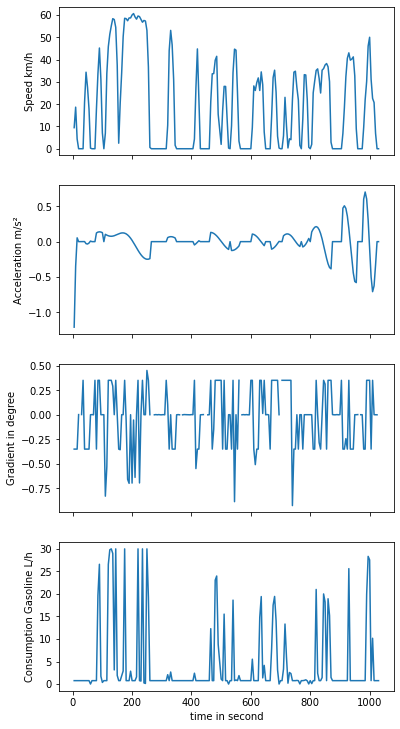

In [12]:
f, axarr = plt.subplots(4, sharex=True)
figsize=(8, 6)
time_interval = np.array(one_track['time_interval'])
speed = np.array(one_track['speed']) / 0.27777
acceleration = np.array(one_track['Acceleration'])
Consumption_Gasoline = np.array(one_track['Consumption_Gasoline'])
gradient = np.array(one_track['gradient'])
#engine_power = np.array(realistc_drive['engine_power']) 



axarr[0].plot(time_interval , speed)
axarr[1].plot(time_interval , acceleration)
axarr[2].plot(time_interval , gradient)
axarr[3].plot(time_interval , Consumption_Gasoline)
#axarr[4].plot(time_interval , engine_power)


axarr[3].set_xlabel('time in second')
axarr[0].set_ylabel('Speed km/h')
axarr[1].set_ylabel('Acceleration m/s²')
axarr[2].set_ylabel('Gradient in degree')
#axarr[3].set_ylabel('Engine Power Kw')
axarr[3].set_ylabel('Consumption Gasoline L/h')


plt.subplots_adjust(top=2.5)
filename = "E:\\Munster\\Floating Car\\Group Assignmnet 2\\fcda.png"
plt.savefig(filename, format= 'png', bbox_inches='tight' )

## The most efficient route

In [ ]:
import plotly.express as px
tracks['lat'] = tracks['geometry'].apply(lambda coord: coord.y)
tracks['lng'] = tracks['geometry'].apply(lambda coord: coord.x)
tracks.dropna()
#print (tracks)
some_track_flat = tracks[tracks['track.id'] == one_track_id]
#print(some_track_flat)
fig = px.scatter_mapbox(tracks, lat="lat", lon="lng", color="Consumption_Gasoline")
fig.update_layout(mapbox_style="open-street-map")
fig.show()

## The fastest/shortest route

In [ ]:
import osmnx as ox

G = ox.graph_from_bbox(51.974045, 51.952343, 7.65083, 7.603312, network_type='drive')
orig = list(G)[1]
dest = list(G)[-1]

hwy_speeds = {'residential': 35,
              'secondary': 50,
              'tertiary': 60}
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

route1 = nx.shortest_path(G, orig, dest, weight='time')
route = nx.shortest_path(G, orig, dest, weight='length')
fig, ax = ox.plot_graph_route(G, route1, edge_color= 'blue')


## Convert the OSM Netwok to geodataframe and filter the attributes

In [ ]:
nodes, streets = ox.graph_to_gdfs(G)
road_network = streets[['maxspeed','length','surface']]
road_network
#to check the type of surface "for rolling coff."
for i in road_network.index:
    if road_network.loc[i, 'surface'] == "asphalt":
        road_network.loc[i, 'rolling_resistance'] = 0.02 # source: engineeringtoolbox.com
    elif road_network.loc[i, 'surface'] == "cobblestone":
        road_network.loc[i, 'rolling_resistance'] = 0.015 # source: engineeringtoolbox.com
    elif road_network.loc[i, 'surface'] == "paving_stones":
        road_network.loc[i, 'rolling_resistance'] = 0.033 # source: The Automotive Chassis book
    else:
        road_network.loc[i, 'rolling_resistance'] = 0.02
        
road_network

## plot graph on osm

In [19]:
ox.plot_graph_folium(G, graph_map=None, popup_attribute=None, tiles='cartodbpositron', zoom=1, fit_bounds=True, edge_color='#333333', edge_width=2, edge_opacity=1)

In [27]:
streets1 = streets
streets1['co2'] = int(0)

In [ ]:
for i in one_track.index:
    lat= one_track.loc[i,'geometry'].y
    lng= one_track.loc[i,'geometry'].x
    u1,v1,key = (ox.get_nearest_edge(G, (lat, lng)))
    index = streets1[(streets1.u ==u1) & (streets1.v ==v1)].index
    num = index.array[0]
    streets1.loc[index.array[0],'co2'] += one_track.loc[i,'CO2_Gasoline']
#geom,u,v,key = (ox.get_nearest_edge(G, (51.95395646644701, 7.651804248986446)))


In [48]:
#check accumulate co2 on a certain edge
streets1.loc[70,'co2']

4977.163858649075

In [65]:
graph2 = ox.graph_from_gdfs(nodes, streets1)
